# Technical Indicators - Forest Model

Just exploring the model now. After offloading some of the code to Python modules, the code should be much simpler.

In [1]:
# Auto reload local files
%load_ext autoreload
%autoreload 2
# Make files in src/ available to notebook
import sys
if 'src' not in sys.path:
    sys.path.insert(0, 'src')


import numpy as np

from technical_signals import TechnicalSignals, percent_change
import datastore as ds

In [6]:
from sklearn.model_selection import train_test_split

#spy_constituents = pd.read_csv('../data/spy_constituents.csv')
ticker = "AMZN"
ds.download_daily_candlesticks([ticker], "2000-01-01", "2023-05-07")
data = ds.get_daily_candlesticks([ticker], "2000-01-01", "2023-06-06")[ticker]
tsigs = TechnicalSignals(data, predict_window=7)
X, y, Xy_date = tsigs.toXy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
Xy_test_date = Xy_date.iloc[-y_test.shape[0]:]

[*********************100%***********************]  1 of 1 completed
(5670,)


/home/jared/.local/share/virtualenvs/notebooks-AmY4tn1L/lib/python3.10/site-packages/ta/trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
/home/jared/.local/share/virtualenvs/notebooks-AmY4tn1L/lib/python3.10/site-packages/ta/trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)


Correctly predicted direction of change 80.63943161634103% of the time
Up 47.60213143872114% of the time
MSE Loss: 0.3799901497903724
Standard deviation: actual = 0.9818282850549679, predicted = 0.5951744794897582


<IPython.core.display.Javascript object>


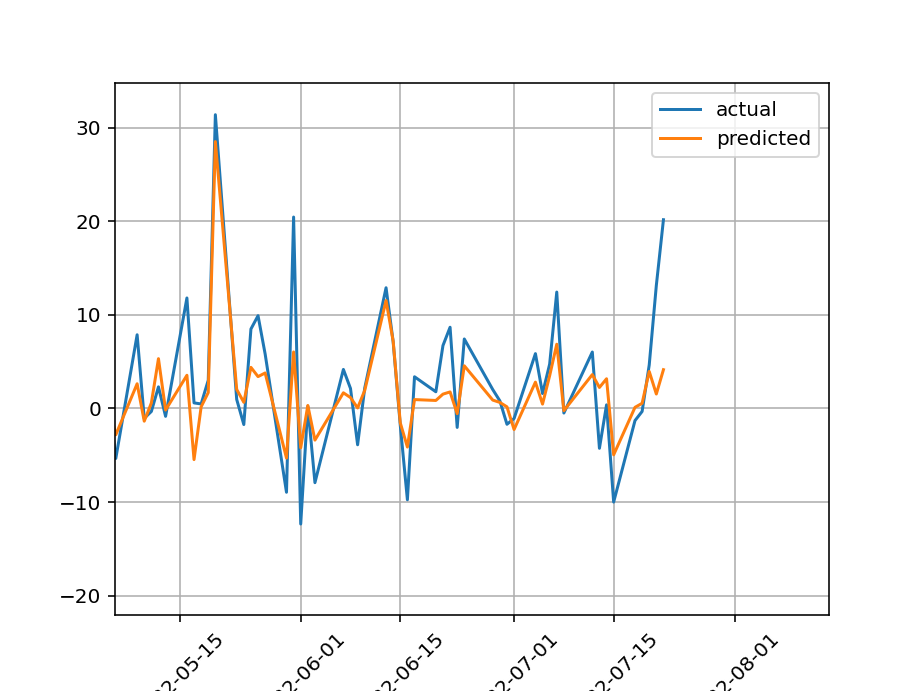

In [7]:
%matplotlib notebook
from datetime import timedelta
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

signal_model = RandomForestRegressor()
signal_model.fit(X_train, y_train)

# Test
def test_model(model, X_test, y_test):
    # Predict
    y_predicted = model.predict(X_test)
    # Error and % correct
    loss = np.mean(np.square(y_predicted - y_test))
    correct = ((y_predicted > 0) == (y_test > 0)).sum() / len(y_predicted) * 100
    up = (y_test > 0).sum() / len(y_test) * 100
    print(f'Correctly predicted direction of change {correct}% of the time')
    print(f'Up {up}% of the time')
    print('MSE Loss:', loss)
    print(f'Standard deviation: actual = {np.std(y_test)}, predicted = {np.std(y_predicted)}')
    
    
    predicted_dates = Xy_test_date.apply(lambda dt: dt + timedelta(days=tsigs.predict_window))
    # Plot of percent change
    y_test = tsigs.y_scaler.inverse_transform(y_test.reshape(-1, 1))[:, 0]
    y_predicted = tsigs.y_scaler.inverse_transform(y_predicted.reshape(-1, 1))[:, 0]
    fig, ax=plt.subplots(dpi=72*2)
    ax.plot(predicted_dates, y_test, label="actual")
    ax.plot(predicted_dates, y_predicted, label="predicted")
    plt.xticks(rotation=45)
    plt.grid()
    ax.legend()
    plt.show()

test_model(signal_model, X_test, y_test)

Mean % change: 1.8644591036709401
Total % change: 13.05121372569658


<IPython.core.display.Javascript object>


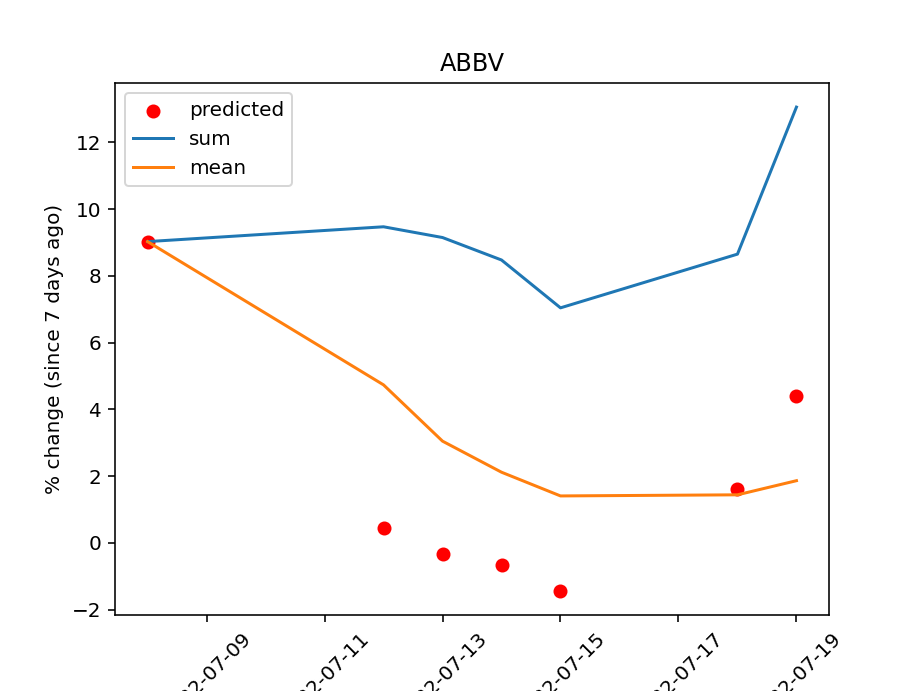

0      -3.616175
1      -2.124610
2       0.610640
3       3.134074
4       8.039155
          ...   
2393         NaN
2394         NaN
2395         NaN
2396         NaN
2397         NaN
Name: pchange_7day, Length: 2398, dtype: float64

In [10]:
def moving_average(a):
    return np.cumsum(a, dtype=float) / np.arange(1, a.shape[0]+1)

def predict_future_changes(model, tsigs):
    # Find rows where the label is nan
    # TODO find a better way, not mutable
    oldsigs = tsigs.signals
    tsigs.signals = tsigs.signals[np.isnan(tsigs.signals[tsigs.label_key])]
    X, date = tsigs.toX()
    # predict
    y_predicted = model.predict(X)
    # scale
    y_predicted = tsigs.y_scaler.inverse_transform(y_predicted.reshape(-1, 1))[:, 0]
    
    predicted_dates = date.apply(lambda dt: dt + timedelta(days=tsigs.predict_window))
    
    print(f'Mean % change: {np.mean(y_predicted)}')
    print(f'Total % change: {np.sum(y_predicted)}')
    # Plot of percent change
    fig, ax=plt.subplots(dpi=72*2)
    ax.scatter(predicted_dates, y_predicted, label="predicted", color="red")
    ax.plot(predicted_dates, np.cumsum(y_predicted), label="sum")
    ax.plot(predicted_dates, moving_average(y_predicted), label="mean")
    plt.title(ticker)
    plt.ylabel(f"% change (since {tsigs.predict_window} days ago)")
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()
    # XXX reset mutable changes at top
    tsigs.signals = oldsigs
    
predict_future_changes(signal_model, tsigs)
tsigs.signals[tsigs.label_key]

Latest data: 2022-07-12 00:00:00
2391   2022-07-01
2392   2022-07-05
2393   2022-07-06
2394   2022-07-07
2395   2022-07-08
2396   2022-07-11
2397   2022-07-12
Name: date, dtype: datetime64[ns]
2391   2022-07-08
2392   2022-07-12
2393   2022-07-13
2394   2022-07-14
2395   2022-07-15
2396   2022-07-18
2397   2022-07-19
Name: date, dtype: datetime64[ns]


<IPython.core.display.Javascript object>


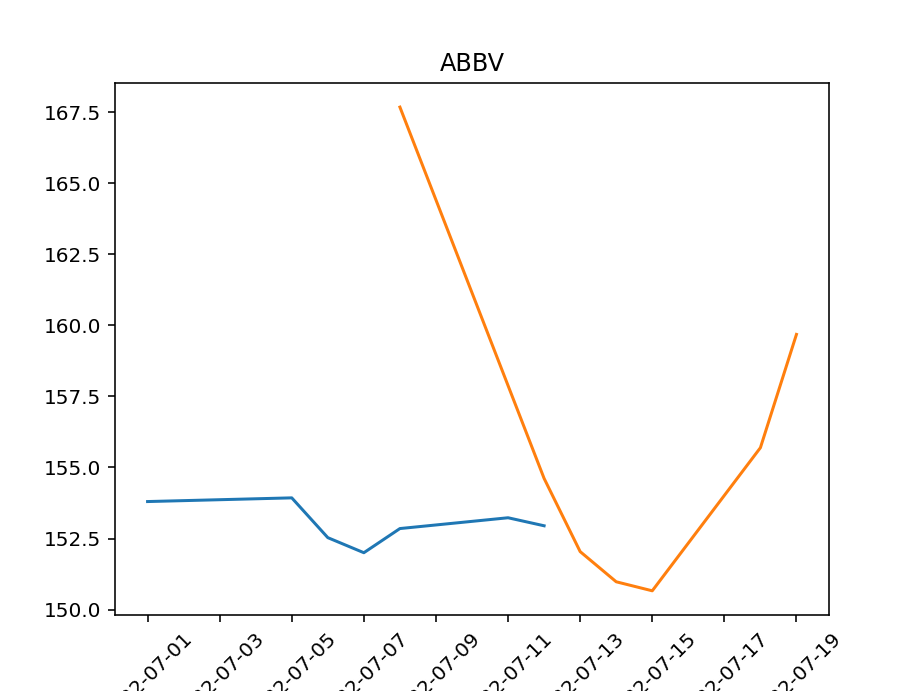

In [11]:
# NOT CORRECT
# This model is not designed to predict prices. This code attempts
# to force the output into specific prices, but it doesn't always
# make sense.
from datetime import timedelta

def predict_future_prices(model, data, tsigs):
    # Find rows where the label is nan
    # TODO find a better way, not mutable
    oldsigs = tsigs.signals
    tsigs.signals = tsigs.signals[np.isnan(tsigs.signals[tsigs.label_key])]
    X, date = tsigs.toX()
    # predict
    y_predicted = model.predict(X)
    # scale
    y_predicted = tsigs.y_scaler.inverse_transform(y_predicted.reshape(-1, 1))[:, 0]
    
    # Compute actual predicted prices
    n = tsigs.predict_window
    n_days_ago = data["close"].to_numpy()[-n:]
    predicted_prices = n_days_ago + y_predicted * 0.01 * n_days_ago
    print(date)
    
    predicted_dates = date.apply(lambda dt: dt + timedelta(days=n))
    print(predicted_dates)

    # Plot of percent change
    fig, ax=plt.subplots(dpi=72*2)
    ax.plot(date, n_days_ago, label="previous")
    ax.plot(predicted_dates, predicted_prices, label="predicted")
    plt.title(ticker)
    plt.xticks(rotation=45)
    plt.show()
    # XXX reset mutable changes at top
    tsigs.signals = oldsigs

print(f'Latest data: {data.iloc[-1]["date"]}')
predict_future_prices(signal_model, data, tsigs)

## Conclusion

This model is excellent for predicting whether the price of an asset will go up or down, from a week to months out. Trying to pull out specific price data from this model would be difficult, but the raw output is actionable in itself.